In [1]:
!pip install ipywidgets widgetsnbextension folium

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [57]:
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import IPython
import sys
import os

import torch
from torch.nn import CosineSimilarity

In [58]:
import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.feature_extraction import create_feature_extractor

# Pytorch GPU 情報確認

In [59]:
torch.__version__

'1.13.0a0+08820cb'

In [60]:
torch.cuda.is_available()

True

In [61]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [62]:
device = torch.device("cuda:0")

# Table 生成

In [63]:
pickle_file_path = './out/features.pkl'
image_dir = './out/'

In [64]:
def load_images(df):
    print('listing un-recorded files...')
    
    filename_list = [f for f in os.listdir(image_dir) if f.endswith('.png') and f not in df.index]

    print(f'NEW {len(filename_list)} images found.')
    print('image loading...')
    
    img_list = [Image.open(image_dir + f).convert('RGB') for f in tqdm(filename_list)]

    print('Complete!')

    return filename_list, img_list

In [65]:
def extract_features(img_list):
    preprocess = T.Compose([
        T.CenterCrop(224),
        T.ToTensor(),
    ])

    input_images = torch.stack([preprocess(img) for img in img_list]).to(device)

    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
    feature_extractor = create_feature_extractor(model, {"avgpool": "feature"})

    fea_dict = feature_extractor(input_images)
    
    del model
    
    return fea_dict['feature']

## 特徴データを格納したDataFrameを読み込み

In [67]:
df = []
if os.path.isfile(pickle_file_path):
    df = pd.read_pickle(pickle_file_path)
else:
    df = pd.DataFrame(columns=['longitude', 'latitude', 'feature',])
    df.to_pickle(pickle_file_path)

### 現状出力

In [68]:
df = pd.read_pickle(pickle_file_path)
print(f'{len(df)} records found.')
df.head()

0 records found.


,longitude,latitude,feature


### Load開始

In [69]:
name_list, img_list = load_images(df)

listing un-recorded files...
NEW 24939 images found.
image loading...


100%|██████████| 24939/24939 [00:24<00:00, 1008.33it/s]

Complete!


In [70]:
batch = 1000
img_list_set  = [img_list[i:i+batch]  for i in range(0, len(img_list), batch)]

with torch.inference_mode():
    features = [extract_features(img_set).to('cpu').detach().numpy().copy() for img_set in tqdm(img_list_set)]

torch.cuda.empty_cache()

features = np.concatenate(features)

100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


In [71]:
for i in tqdm(range(len(features))):
    df.loc[name_list[i]] = [
            name_list[i].split(',')[0],
            name_list[i].split(',')[1][:-4],
            features[i].squeeze(2).squeeze(1)
    ]

100%|██████████| 24939/24939 [00:57<00:00, 434.35it/s]


In [73]:
df.to_pickle(pickle_file_path)

In [17]:
# !rm out/features.pkl

# 検索

In [74]:
embed_features_np = np.vstack(df['feature'].values)
embed_features = torch.from_numpy(embed_features_np).to(device)

In [75]:
user_img_path = './test.png'
user_img = Image.open(user_img_path).convert('RGB')

with torch.inference_mode():
    user_f = extract_features([user_img]).squeeze(3).squeeze(2) #.to('cpu').detach().numpy().copy().squeeze(3).squeeze(2)
# torch.cuda.empty_cache()

In [76]:
user_f_expanded = user_f.expand(embed_features.shape[0], 512)
user_f_expanded.shape

torch.Size([24939, 512])

In [77]:
cos_sim = CosineSimilarity(dim=1)
sim_tensor = cos_sim(user_f_expanded, embed_features)

In [78]:
recommend_num = 1000
recommend_args = torch.argsort(sim_tensor, descending=True)[:recommend_num].to('cpu').detach().numpy().copy()

### 可視化

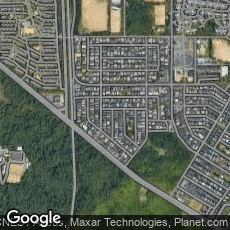

In [79]:
user_img

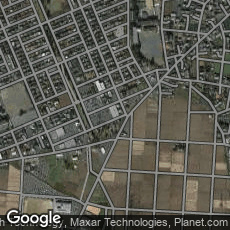

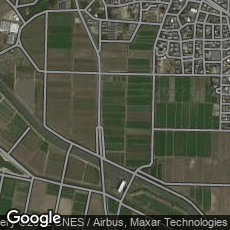

In [80]:
for r in recommend_args[:2]:
    IPython.display.display(Image.open(image_dir + df.index[r]))

In [36]:
import folium

In [81]:
rec_p = [[float(df.index[r].split(',')[0]), float(df.index[r].split(',')[1][:-4])] for r in recommend_args]
rec_p[:10]

[[36.285451, 139.33457],
 [34.696549, 137.946496],
 [36.269451, 139.16457],
 [34.713996, 136.486291],
 [36.109776, 140.218836],
 [35.861776, 140.338836],
 [36.085451, 139.76457],
 [36.093451, 139.42457],
 [36.085776, 140.218836],
 [36.018263, 139.98638]]

In [88]:
import json
json.dumps({'count': 10, 'areas': [{"lat": rec[0], "lng": rec[1]} for rec in rec_p[:10]]})

'{"count": 10, "areas": [{"lat": 36.285451, "lng": 139.33457}, {"lat": 34.696549, "lng": 137.946496}, {"lat": 36.269451, "lng": 139.16457}, {"lat": 34.713996, "lng": 136.486291}, {"lat": 36.109776, "lng": 140.218836}, {"lat": 35.861776, "lng": 140.338836}, {"lat": 36.085451, "lng": 139.76457}, {"lat": 36.093451, "lng": 139.42457}, {"lat": 36.085776, "lng": 140.218836}, {"lat": 36.018263, "lng": 139.98638}]}'

In [84]:
center = np.array(rec_p[:10]).mean(axis=0)
map1 = folium.Map(location=center, zoom_start=15)
for geo in rec_p[:10]:
  folium.Marker(geo).add_to(map1)
map1